# Matrix Factorization

> Netfilx contest

## The Matrix Factorization Model

Matrix factorization
- a class of collaborative filtering models
- factorizes the user-item interaction matrix *rating matrix* 
  - into the product of two **lower-rank** matrices
- $\mathbf{R} \in \mathbb{R}^{m \times n}$
  - rating matrix
  - $m$ users and $n$ items
  - $\mathbf{R}_{ij}$ represents explicit rating of user $i$ on item $j$
- The user-item interaction matrix will be factorized into two matrices
  - $\mathbf{P} \in \mathbb{R}^{m \times k}$
    - user latent factors
  - $\mathbf{Q} \in \mathbb{R}^{n \times k}$
    - item latent factors
  - $k$ is the latent factor size
    - $k \ll m, n$
  - let $\mathbf{p}_u \in \mathbb{R}^k$ be the latent factor vector of user $u$
  - let $\mathbf{q}_i \in \mathbb{R}^k$ be the latent factor vector of item $i$
    - $\mathbf{q}_i$ measures the extent to which item $i$ possesses those factors 
      - e.g. genre, director, actors, etc.
      - $\mathbf{q}_i$ is a vector of weights
    - $\mathbf{p}_u$ measures the extent to which user $u$ likes items that are high on the corresponding factors
      - $\mathbf{p}_u$ is a vector of weights
- The predicted rating of user $u$ on item $i$ is
  - $\hat{\mathbf{R}}_{ui} = \mathbf{p}_u^\top \mathbf{q}_i$
$$
\hat{\mathbf{R}} = \mathbf{PQ}^\top
$$
- Consider users/items biases, we have
$$
\hat{\mathbf{R}}_{ui} = \mathbf{p}_u\mathbf{q}^\top_i + b_u + b_i
$$
- The objective function is
$$
\underset{\mathbf{P}, \mathbf{Q}, b}{\mathrm{argmin}} \sum_{(u, i) \in \mathcal{K}} \| \mathbf{R}_{ui} -
\hat{\mathbf{R}}_{ui} \|^2 + \lambda (\| \mathbf{P} \|^2_F + \| \mathbf{Q}
\|^2_F + b_u^2 + b_i^2 )
$$

![mf](images/rec-mf.svg)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=num_factors)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        for param in self.parameters():
            nn.init.normal_(param, std=0.01)

    def forward(self, user_id, item_id):
        """
        @param user_id: torch.LongTensor of shape (batch_size, 1)
        @param item_id: torch.LongTensor of shape (batch_size, 1)
        """
        P_u = self.user_embedding(user_id)
        Q_i = self.item_embedding(item_id)
        b_u = self.user_bias(user_id).flatten()
        b_i = self.item_bias(item_id).flatten()
        outputs = (P_u * Q_i).sum(axis=1) + b_u + b_i
        return outputs.flatten()

## Evaluation Measures

- Root Mean Square Error (RMSE)

$$
\textrm{RMSE} = \sqrt{\frac{1}{|\mathcal{T}|}\sum_{(u, i) \in \mathcal{T}}(\mathbf{R}_{ui} -\hat{\mathbf{R}}_{ui})^2}
$$
where
- $\mathcal{T}$ is the test set
  - $|\mathcal{T}|$ is the size of the test set

In [2]:
# refer https://discuss.pytorch.org/t/rmse-loss-function/16540/3
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

## Train

In [3]:
import utils
num_users, num_items, train_iter, test_iter = utils.split_and_load_ml100k(
    test_ratio=0.1, batch_size=16
)

In [4]:
model = MF(30, num_users, num_items)
loss_fn = RMSELoss()
learning_rate, weight_decay = 0.002, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


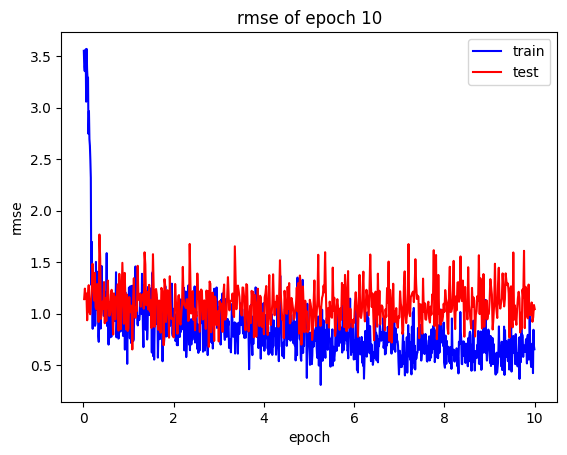

In [5]:
import animator
ani = animator.Animator()
num_epochs = 10
train_epoch_perc = []
train_loss = []
test_epoch_perc = []
test_loss = []
for epoch in range(num_epochs):
    # print(f"Epoch {epoch+1}\n-------------------------------")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for batch, values in enumerate(train_iter):
        # Compute prediction and loss
        u, i, r = values 
        u, i, r = u.to(device), i.to(device), r.to(device)
        pred = model(u, i)
        loss = loss_fn(pred, r.float()) #loss_fn(pred, r.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % 64 == 0:
            # print("batch: {}, loss: {:.2f}".format(batch+1, loss.item()))
            train_epoch_perc.append((batch+1)/ len(train_iter) + epoch)
            train_loss.append(loss.item())

    
    with torch.no_grad():
        for batch, values in enumerate(test_iter):
            u, i, r = values
            u, i, r = u.to(device), i.to(device), r.to(device)
            pred = model(u, i)
            loss = loss_fn(pred, r.float())
            # print("RMSE: {:.2f}".format(loss.item()))
            test_epoch_perc.append((batch+1)/ len(test_iter) + epoch)
            test_loss.append(loss.item())

    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='train')
    ani.ax.plot(test_epoch_perc,  test_loss,  color='r', label='test')
    ani.ax.set_xlabel('epoch')
    ani.ax.set_ylabel('rmse')
    ani.ax.legend()
    ani.ax.set_title(f'rmse of epoch {epoch+1}')
    ani.render()

ani.close()
# print("Done!")